## ***Adversarial Attacks on Neural Networks (Deep Learning Final Project)***

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.layers as L
from tensorflow.keras.datasets import mnist, cifar10

import numpy as np
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm

In [38]:
def print_shapes(x_train, x_test, y_train, y_test):
  print(f"x_train: {x_train.shape}\n"\
      f"x_test: {x_test.shape}\n"\
      f"y_train: {y_train.shape}\n"\
      f"y_test: {y_test.shape}\n")

In [39]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print_shapes(x_train, x_test, y_train, y_test)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 1)
y_test: (10000, 1)



In [40]:
len(x_train)

50000

In [41]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape((-1, height, width, channels))
x_test = x_test.reshape((-1, height, width, channels))

y_train = tf.keras.utils.to_categorical(y_train, nb_classes)
y_test = tf.keras.utils.to_categorical(y_test, nb_classes)

print_shapes(x_train, x_test, y_train, y_test)

x_train: (50000, 32, 32, 3)
x_test: (10000, 32, 32, 3)
y_train: (50000, 10)
y_test: (10000, 10)



In [42]:
model_path = '/content/drive/MyDrive/deep_learning_dataset/Weights_cnn_trans0.3_ep300.h5'
model_cnn = tf.keras.models.load_model(model_path)
model_fcn_n_5_path = '/content/drive/MyDrive/deep_learning_dataset/Weights_fcn_trans0.3_ep300.h5'
model_fcn = tf.keras.models.load_model(model_fcn_n_5_path)

In [43]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 128)         204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                                 
 dense_1 (Dense)             (None, 10)                10250     
                                                                 
Total params: 2875530 (10.97 MB)
Trainable params: 28755

In [44]:
model_fcn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 locally_connected2d (Local  (None, 14, 14, 64)        953344    
 lyConnected2D)                                                  
                                                                 
 locally_connected2d_1 (Loc  (None, 5, 5, 128)         5123200   
 allyConnected2D)                                                
                                                                 
 locally_connected2d_2 (Loc  (None, 3, 3, 256)         2656512   
 allyConnected2D)                                                
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 1024)              2360320   
                                                        

In [45]:
def generate_adversary(image, label, model):
  image = tf.cast(image, tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = model(image)
    loss = tf.keras.losses.MSE(label, prediction)
  gradient = tape.gradient(loss, image)
  sign_grad = tf.sign(gradient)

  return sign_grad

(32, 32, 3)
Prediction from CNN: automobile


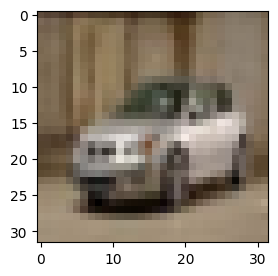

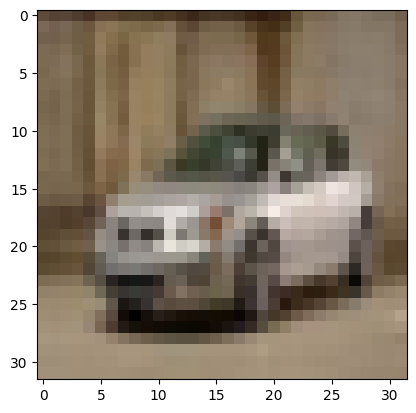

In [46]:
rand_idx = randint(0,49999)
print(x_train[rand_idx].shape)
image = x_train[rand_idx].reshape((1, height, width, channels))
label = y_train[rand_idx]

print(f'Prediction from CNN: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

plt.imshow(x_train[rand_idx])
plt.show()

In [47]:
perturbations = generate_adversary(image,label,model_cnn).numpy()
adversarial = image + (perturbations * 0.05)

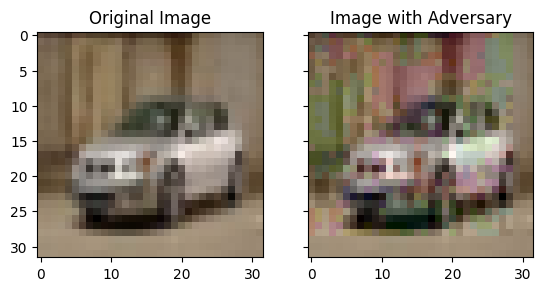

In [48]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [49]:
print(f'Normal Image Prediction: {label_names[model_cnn.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model_cnn.predict(adversarial).argmax()]}")

1/1 [==============================] - 0s 85ms/step
Normal Image Prediction: automobile
1/1 [==============================] - 0s 22ms/step
Adversary Prediction: truck


In [50]:
perturbations = generate_adversary(image,label,model_fcn).numpy()
adversarial = image + (perturbations * 0.05)

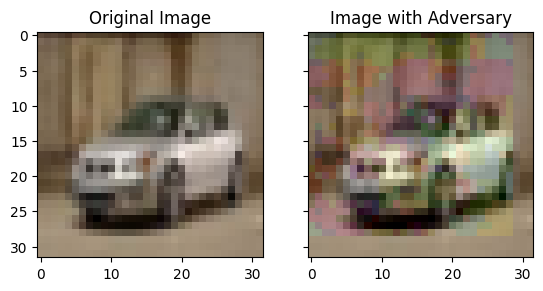

In [51]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
ax2.imshow(adversarial.reshape(height,width, channels))
ax2.set_title("Image with Adversary")
plt.show()

In [52]:
print(f'Normal Image Prediction: {label_names[model_fcn.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model_fcn.predict(adversarial).argmax()]}")

1/1 [==============================] - 1s 1s/step
Normal Image Prediction: truck
1/1 [==============================] - 0s 31ms/step
Adversary Prediction: horse


## **FOR MODELS WITH 300 EPOCHS DURING TRAINING** ##

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from tensorflow.keras.datasets import cifar10
import tensorflow as tf

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocessing
height, width, channels = 32, 32, 3
nb_classes = 10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_train = x_train / 255.0
x_train = x_train.reshape((-1, height, width, channels))
y_train = tf.keras.utils.to_categorical(y_train, nb_classes)

# Load models

model_path = '/content/drive/MyDrive/deep_learning_dataset/Weights_cnn_trans0.3_ep300.h5'
model_cnn = tf.keras.models.load_model(model_path)
model_fcn_n_5_path = '/content/drive/MyDrive/deep_learning_dataset/Weights_fcn_trans0.3_ep300.h5'
model_fcn = tf.keras.models.load_model(model_fcn_n_5_path)

# Adversary generation function
def generate_adversary(image, label, model):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    gradient = tape.gradient(loss, image)
    sign_grad = tf.sign(gradient)
    return sign_grad

# Running the adversarial attack 100 times
results = []
for i in range(1000):
    rand_idx = randint(0, len(x_train) - 1)
    image = x_train[rand_idx].reshape((1, height, width, channels))
    label = y_train[rand_idx]
    print (label)

    true_label_idx = np.argmax(label)  # Get the index of the true label
    true_label = label_names[true_label_idx]
    print(true_label)

    # For model
    perturbations = generate_adversary(image, label, model_cnn).numpy()
    adversarial = image + (perturbations * 0.05)
    normal_pred = label_names[model_cnn.predict(image).argmax()]
    print(normal_pred)
    adversary_pred = label_names[model_cnn.predict(adversarial).argmax()]

    # For model_fcn_n_5
    perturbations_fcn = generate_adversary(image, label, model_fcn).numpy()
    adversarial_fcn = image + (perturbations_fcn * 0.05)
    normal_pred_fcn = label_names[model_fcn.predict(image).argmax()]
    adversary_pred_fcn = label_names[model_fcn.predict(adversarial_fcn).argmax()]

    # Store the results
    results.append({
        "iteration": i,
        "true_label": true_label,
        "normal_pred": normal_pred,
        "adversary_pred": adversary_pred,
        "normal_pred_fcn": normal_pred_fcn,
        "adversary_pred_fcn": adversary_pred_fcn
    })



[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
airplane
1/1 [==============================] - 0s 119ms/step
ship
1/1 [==============================] - 0s 28ms/step


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 37ms/step
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
horse
1/1 [==============================] - 0s 35ms/step
horse
1/1 [==============================] - 0s 48ms/step
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
frog
1/1 [==============================] - 0s 31ms/step
frog
1/1 [==============================] - 0s 36ms/step
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
automobile
1/1 [==============================] - 0s 31ms/step
automobile
1/1 [==============================] - 0s 25ms/step
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
dog
1/1 [==============================] - 0s 22ms/step
cat
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
ship
1/1 [==============================] - 0s 20ms/step
automobile
1/1 [==============================] - 0s 24ms/step
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
deer
1/1 [==============================] - 0s 21ms/step
bird
1/1 [==============================] - 0s 26ms/step
[0.

In [54]:
print(results)

[{'iteration': 0, 'true_label': 'airplane', 'normal_pred': 'ship', 'adversary_pred': 'ship', 'normal_pred_fcn': 'horse', 'adversary_pred_fcn': 'horse'}, {'iteration': 1, 'true_label': 'automobile', 'normal_pred': 'automobile', 'adversary_pred': 'automobile', 'normal_pred_fcn': 'automobile', 'adversary_pred_fcn': 'truck'}, {'iteration': 2, 'true_label': 'bird', 'normal_pred': 'bird', 'adversary_pred': 'cat', 'normal_pred_fcn': 'cat', 'adversary_pred_fcn': 'cat'}, {'iteration': 3, 'true_label': 'dog', 'normal_pred': 'dog', 'adversary_pred': 'cat', 'normal_pred_fcn': 'cat', 'adversary_pred_fcn': 'bird'}, {'iteration': 4, 'true_label': 'horse', 'normal_pred': 'horse', 'adversary_pred': 'deer', 'normal_pred_fcn': 'horse', 'adversary_pred_fcn': 'cat'}, {'iteration': 5, 'true_label': 'automobile', 'normal_pred': 'automobile', 'adversary_pred': 'truck', 'normal_pred_fcn': 'truck', 'adversary_pred_fcn': 'truck'}, {'iteration': 6, 'true_label': 'bird', 'normal_pred': 'bird', 'adversary_pred': 'd

In [55]:
import pandas as pd

# Convert results to pandas DataFrame for easy tabular display
results_df = pd.DataFrame(results)
print(results_df)

# Counters for successful attacks and correct predictions
successful_attacks_model = 0
successful_attacks_model_fcn_n_5 = 0
correct_predictions_model = 0
correct_predictions_model_fcn_n_5 = 0

# Iterate over results to count successful attacks and correct predictions
for i, result in enumerate(results):
    #true_label_idx = np.argmax(y_train[i])  # Get the index of the true label
    true_label = result['true_label']  # Get the true label name

    # Check correct prediction and successful attack for model
    if true_label == result['normal_pred']:
        correct_predictions_model += 1
        if result['normal_pred'] != result['adversary_pred']:
            successful_attacks_model += 1

    # Check correct prediction and successful attack for model_fcn_n_5
    if true_label == result['normal_pred_fcn']:
        correct_predictions_model_fcn_n_5 += 1
        if result['normal_pred_fcn'] != result['adversary_pred_fcn']:
            successful_attacks_model_fcn_n_5 += 1

# Print results
print(f"Correct predictions by CNN model: {correct_predictions_model}")
print(f"Correct predictions by model_fcn_n_5: {correct_predictions_model_fcn_n_5}")
print(f"Number of successful attacks on CNN model: {successful_attacks_model}")
print(f"Number of successful attacks on model_fcn_n_5: {successful_attacks_model_fcn_n_5}")


     iteration  true_label normal_pred adversary_pred normal_pred_fcn  \
0            0    airplane        ship           ship           horse   
1            1  automobile  automobile     automobile      automobile   
2            2        bird        bird            cat             cat   
3            3         dog         dog            cat             cat   
4            4       horse       horse           deer           horse   
..         ...         ...         ...            ...             ...   
995        995         cat         cat           frog             cat   
996        996    airplane    airplane     automobile        airplane   
997        997        deer        deer           bird            deer   
998        998    airplane    airplane           ship        airplane   
999        999         dog         dog           frog             dog   

    adversary_pred_fcn  
0                horse  
1                truck  
2                  cat  
3                 bird 

In [56]:
# Ensure that the correct predictions are non-zero to avoid division by zero
if correct_predictions_model > 0:
    percentage_successful_attacks_model = (successful_attacks_model / correct_predictions_model) * 100
else:
    percentage_successful_attacks_model = 0

if correct_predictions_model_fcn_n_5 > 0:
    percentage_successful_attacks_model_fcn_n_5 = (successful_attacks_model_fcn_n_5 / correct_predictions_model_fcn_n_5) * 100
else:
    percentage_successful_attacks_model_fcn_n_5 = 0

print(f"Percentage of successful attacks on CNN model: {percentage_successful_attacks_model:.2f}%")
print(f"Percentage of successful attacks on model_fcn_n_5: {percentage_successful_attacks_model_fcn_n_5:.2f}%")


Percentage of successful attacks on CNN model: 93.56%
Percentage of successful attacks on model_fcn_n_5: 95.53%


## **FOR MODELS WITH 300 EPOCHS DURING TRAINING WITH MODIFIED CALCULATIONS** ##

In [65]:
import pandas as pd

# Convert results to pandas DataFrame for easy tabular display
results_df = pd.DataFrame(results)
print(results_df)

# Counters for successful attacks and correct predictions
successful_attacks_model = 0
successful_attacks_model_fcn_n_5 = 0
correct_predictions_model = 0
correct_predictions_model_fcn_n_5 = 0

# Iterate over results to count successful attacks and correct predictions
for i, result in enumerate(results):
    #true_label_idx = np.argmax(y_train[i])  # Get the index of the true label
    true_label = result['true_label']  # Get the true label name

    # Check correct prediction and successful attack for model
    if true_label == result['normal_pred'] and true_label == result['normal_pred_fcn']:
        correct_predictions_model += 1
        if result['normal_pred'] != result['adversary_pred']:
            successful_attacks_model += 1
        if result['normal_pred_fcn'] != result['adversary_pred_fcn']:
            successful_attacks_model_fcn_n_5 += 1


# Print results
print(f"Correct predictions by both model: {correct_predictions_model}")
#print(f"Correct predictions by model_fcn_n_5: {correct_predictions_model_fcn_n_5}")
print(f"Number of successful attacks on CNN model: {successful_attacks_model}")
print(f"Number of successful attacks on model_fcn_n_5: {successful_attacks_model_fcn_n_5}")


     iteration  true_label normal_pred adversary_pred normal_pred_fcn  \
0            0        frog        frog           bird            frog   
1            1       horse       horse           deer           horse   
2            2        ship        ship       airplane            ship   
3            3       truck       truck     automobile           truck   
4            4       truck         dog            dog           truck   
..         ...         ...         ...            ...             ...   
995        995       horse        frog           frog           truck   
996        996        ship        ship       airplane            ship   
997        997         dog       horse          horse             dog   
998        998  automobile  automobile            dog      automobile   
999        999        deer        bird           bird            deer   

    adversary_pred_fcn  
0                 deer  
1                 deer  
2             airplane  
3                 deer 

In [63]:
# Ensure that the correct predictions are non-zero to avoid division by zero
if correct_predictions_model > 0:
    percentage_successful_attacks_model = (successful_attacks_model / correct_predictions_model) * 100
else:
    percentage_successful_attacks_model = 0

if correct_predictions_model_fcn_n_5 > 0:
    percentage_successful_attacks_model_fcn_n_5 = (successful_attacks_model_fcn_n_5 / correct_predictions_model) * 100
else:
    percentage_successful_attacks_model_fcn_n_5 = 0

print(f"Percentage of successful attacks on CNN model: {percentage_successful_attacks_model:.2f}%")
print(f"Percentage of successful attacks on model_fcn_n_5: {percentage_successful_attacks_model_fcn_n_5:.2f}%")


Percentage of successful attacks on CNN model: 97.19%
Percentage of successful attacks on model_fcn_n_5: 84.29%


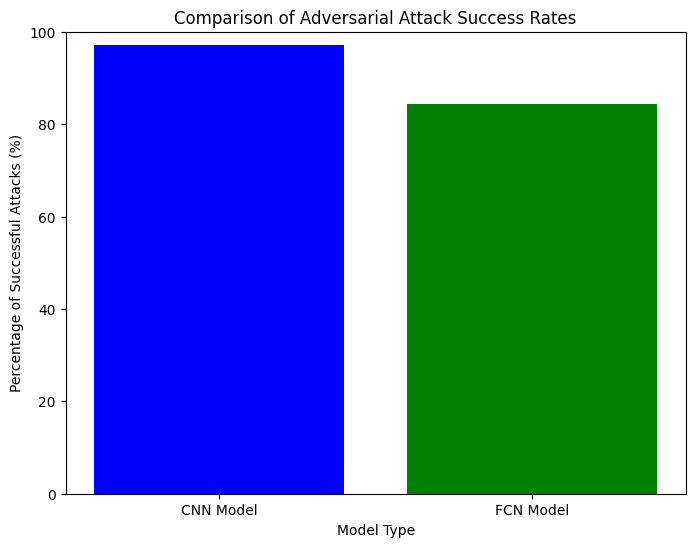

In [64]:
labels = ['CNN Model', 'FCN Model']
percentages = [percentage_successful_attacks_model, percentage_successful_attacks_model_fcn_n_5]

plt.figure(figsize=(8, 6))
plt.bar(labels, percentages, color=['blue', 'green'])
plt.xlabel('Model Type')
plt.ylabel('Percentage of Successful Attacks (%)')
plt.title('Comparison of Adversarial Attack Success Rates')
plt.ylim(0, 100)  # Setting the limit for y-axis for better readability
plt.show()

## **FOR MODELS WITH 100 EPOCHS DURING TRAINING** ##

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from tensorflow.keras.datasets import cifar10
import tensorflow as tf

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Preprocessing
height, width, channels = 32, 32, 3
nb_classes = 10
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_train = x_train / 255.0
x_train = x_train.reshape((-1, height, width, channels))
y_train = tf.keras.utils.to_categorical(y_train, nb_classes)

# Load models

model_path = '/content/drive/MyDrive/deep_learning_dataset/Weights_cnn_trans0.3_ep100.h5'
model_cnn = tf.keras.models.load_model(model_path)
model_fcn_n_5_path = '/content/drive/MyDrive/deep_learning_dataset/Weights_fcn_trans0.3_ep100.h5'
model_fcn = tf.keras.models.load_model(model_fcn_n_5_path)

# Adversary generation function
def generate_adversary(image, label, model):
    image = tf.cast(image, tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.MSE(label, prediction)
    gradient = tape.gradient(loss, image)
    sign_grad = tf.sign(gradient)
    return sign_grad

# Running the adversarial attack 100 times
results = []
for i in range(1000):
    rand_idx = randint(0, len(x_train) - 1)
    image = x_train[rand_idx].reshape((1, height, width, channels))
    label = y_train[rand_idx]
    print (label)

    true_label_idx = np.argmax(label)  # Get the index of the true label
    true_label = label_names[true_label_idx]
    print(true_label)

    # For model
    perturbations = generate_adversary(image, label, model_cnn).numpy()
    adversarial = image + (perturbations * 0.05)
    normal_pred = label_names[model_cnn.predict(image).argmax()]
    print(normal_pred)
    adversary_pred = label_names[model_cnn.predict(adversarial).argmax()]

    # For model_fcn_n_5
    perturbations_fcn = generate_adversary(image, label, model_fcn).numpy()
    adversarial_fcn = image + (perturbations_fcn * 0.05)
    normal_pred_fcn = label_names[model_fcn.predict(image).argmax()]
    adversary_pred_fcn = label_names[model_fcn.predict(adversarial_fcn).argmax()]

    # Store the results
    results.append({
        "iteration": i,
        "true_label": true_label,
        "normal_pred": normal_pred,
        "adversary_pred": adversary_pred,
        "normal_pred_fcn": normal_pred_fcn,
        "adversary_pred_fcn": adversary_pred_fcn
    })


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 39ms/step
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
dog
1/1 [==============================] - 0s 34ms/step
dog
1/1 [==============================] - 0s 48ms/step
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
deer
1/1 [==============================] - 0s 37ms/step
airplane
1/1 [==============================] - 0s 28ms/step
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
bird
1/1 [==============================] - 0s 26ms/step
dog
1/1 [==============================] - 0s 29ms/step
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
bird
1/1 [==============================] - 0s 25ms/step
bird
1/1 [==============================] - 0s 26ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
truck
1/1 [==============================] - 0s 24ms/step
truck
1/1 [==============================] - 0s 29ms/step
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
airplane
1/1 [==============================] - 0s 28ms/step
airplane
1/1 [==============================] - 0s 25ms/step
[0. 1. 0. 

In [61]:
import pandas as pd

# Convert results to pandas DataFrame for easy tabular display
results_df = pd.DataFrame(results)
print(results_df)

# Counters for successful attacks and correct predictions
successful_attacks_model = 0
successful_attacks_model_fcn_n_5 = 0
correct_predictions_model = 0
correct_predictions_model_fcn_n_5 = 0

# Iterate over results to count successful attacks and correct predictions
for i, result in enumerate(results):
    #true_label_idx = np.argmax(y_train[i])  # Get the index of the true label
    true_label = result['true_label']  # Get the true label name

    # Check correct prediction and successful attack for model
    if true_label == result['normal_pred']:
        correct_predictions_model += 1
        if result['normal_pred'] != result['adversary_pred']:
            successful_attacks_model += 1

    # Check correct prediction and successful attack for model_fcn_n_5
    if true_label == result['normal_pred_fcn']:
        correct_predictions_model_fcn_n_5 += 1
        if result['normal_pred_fcn'] != result['adversary_pred_fcn']:
            successful_attacks_model_fcn_n_5 += 1

# Print results
print(f"Correct predictions by CNN model: {correct_predictions_model}")
print(f"Correct predictions by model_fcn_n_5: {correct_predictions_model_fcn_n_5}")
print(f"Number of successful attacks on CNN model: {successful_attacks_model}")
print(f"Number of successful attacks on model_fcn_n_5: {successful_attacks_model_fcn_n_5}")


     iteration  true_label normal_pred adversary_pred normal_pred_fcn  \
0            0        frog        frog           bird            frog   
1            1       horse       horse           deer           horse   
2            2        ship        ship       airplane            ship   
3            3       truck       truck     automobile           truck   
4            4       truck         dog            dog           truck   
..         ...         ...         ...            ...             ...   
995        995       horse        frog           frog           truck   
996        996        ship        ship       airplane            ship   
997        997         dog       horse          horse             dog   
998        998  automobile  automobile            dog      automobile   
999        999        deer        bird           bird            deer   

    adversary_pred_fcn  
0                 deer  
1                 deer  
2             airplane  
3                 deer 

In [62]:
# Ensure that the correct predictions are non-zero to avoid division by zero
if correct_predictions_model > 0:
    percentage_successful_attacks_model = (successful_attacks_model / correct_predictions_model) * 100
else:
    percentage_successful_attacks_model = 0

if correct_predictions_model_fcn_n_5 > 0:
    percentage_successful_attacks_model_fcn_n_5 = (successful_attacks_model_fcn_n_5 / correct_predictions_model_fcn_n_5) * 100
else:
    percentage_successful_attacks_model_fcn_n_5 = 0

print(f"Percentage of successful attacks on CNN model: {percentage_successful_attacks_model:.2f}%")
print(f"Percentage of successful attacks on model_fcn_n_5: {percentage_successful_attacks_model_fcn_n_5:.2f}%")


Percentage of successful attacks on CNN model: 97.19%
Percentage of successful attacks on model_fcn_n_5: 96.49%
